In [32]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer

In [33]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, Dropout, GlobalAveragePooling1D

In [34]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [35]:
np.random.seed(42)
tf.random.set_seed(42)

In [36]:
df = pd.read_csv('IMDB Dataset.csv')
print(f'Dataset shape: {df.shape}')
print(df.head())

Dataset shape: (50000, 2)
                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive


In [37]:
df['sentiment'] = df['sentiment'].map({'positive': 1, 'negative': 0})

In [38]:
X_train, X_test, y_train, y_test = train_test_split(
    df['review'].values,
    df['sentiment'].values,
    test_size=0.2,
    random_state=42,
    stratify=df['sentiment']
)

In [39]:
max_features = 100000  # Only consider top 10k words
maxlen = 200  # Cut texts after 200 words
embedding_dim = 128  # Embedding dimension

In [40]:
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(X_train)

In [41]:
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

In [42]:
X_train_pad = pad_sequences(X_train_seq, maxlen=maxlen)
X_test_pad = pad_sequences(X_test_seq, maxlen=maxlen)

In [47]:
# Build the model - a simple but effective architecture
model = Sequential([
    # Embedding layer to convert words to vectors
    Embedding(max_features, embedding_dim, input_length=maxlen),

    # Global average pooling to reduce dimensionality
    GlobalAveragePooling1D(),

    # Dense hidden layer with dropout for regularization
    Dense(128, activation='relu'),
    Dropout(0.5),

    # Output layer with sigmoid activation for binary classification
    Dense(1, activation='sigmoid')
])

C:\Users\Genius\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [48]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [52]:
model.build(input_shape=(None, maxlen))
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)              │ (None, 200, 128)            │      12,800,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d_4           │ (None, 128)                 │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 12,816,641 (48.89 MB)

 Trainable params: 12,816,641 (48.89 MB)

 Non-trainable params: 0 (0.00 B)

In [53]:
# Train the model with early stopping to prevent overfitting
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

In [54]:
# Training with validation split
history = model.fit(
    X_train_pad, y_train,
    epochs=10,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 165s 164ms/step - accuracy: 0.7275 - loss: 0.5123 - val_accuracy: 0.8441 - val_loss: 0.3374
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 176s 176ms/step - accuracy: 0.9049 - loss: 0.2415 - val_accuracy: 0.8372 - val_loss: 0.3812
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 150s 150ms/step - accuracy: 0.9354 - loss: 0.1730 - val_accuracy: 0.8259 - val_loss: 0.4064
Epoch 4/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 137s 137ms/step - accuracy: 0.9514 - loss: 0.1340 - val_accuracy: 0.8817 - val_loss: 0.3790


In [55]:
# Evaluate on test set
loss, accuracy = model.evaluate(X_test_pad, y_test, verbose=0)
print(f'Test accuracy: {accuracy:.4f}')

# Make predictions
y_pred_prob = model.predict(X_test_pad)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()

# Print classification report
print('\nClassification Report:')
print(classification_report(y_test, y_pred))

# Print confusion matrix
print('\nConfusion Matrix:')
print(confusion_matrix(y_test, y_pred))


Test accuracy: 0.8467
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  

Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.94      0.86      5000
           1       0.92      0.76      0.83      5000

    accuracy                           0.85     10000
   macro avg       0.86      0.85      0.85     10000
weighted avg       0.86      0.85      0.85     10000


Confusion Matrix:
[[4684  316]
 [1217 3783]]


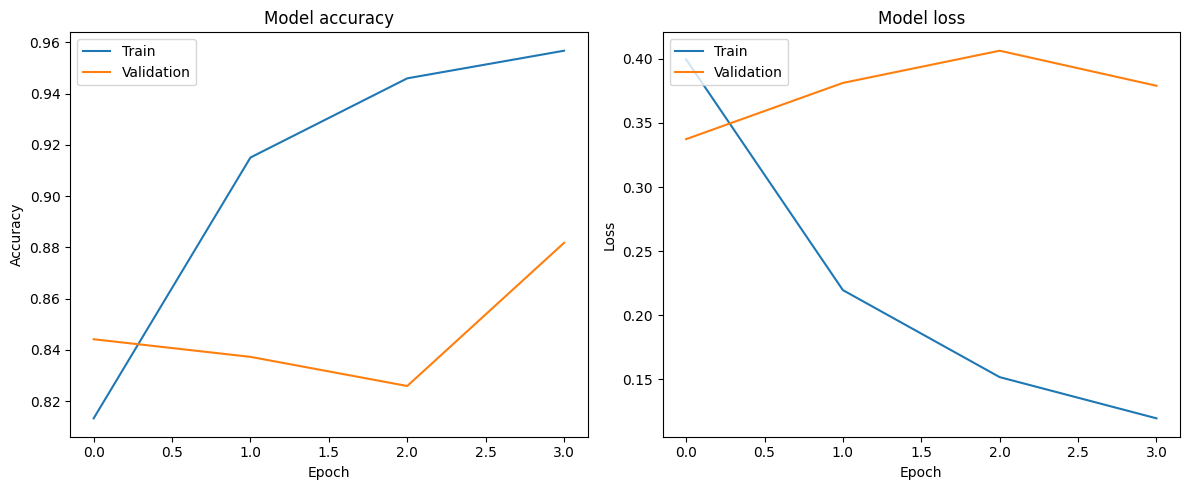

In [56]:
# Plot training history
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()